# 3. Classification

In [1]:
import re
import string
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


In [2]:
import json
import numpy as np
import spacy
from spacy import displacy
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#### Train/Test  Split

## Feature Extraction 
- Train Test Split
- Vectorization TF-IDF Vectorization

In [3]:
df = pd.read_csv("df_processed.csv")

In [4]:
le = LabelEncoder()
le.fit(df.link_flair_text)

LabelEncoder()

In [5]:
df['label'] = le.transform(df.link_flair_text)

### Vectorization 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
vectorizer = TfidfVectorizer(analyzer = "word", max_features=10000)
data = vectorizer.fit_transform(df['text'])

### train set split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.10)

In [9]:
## samples
print(f'Samples in train set = {X_train.shape[0]}\nSamples in test set = {X_test.shape[0]}')

Samples in train set = 48535
Samples in test set = 5393


In [10]:
X_ = X_train.toarray()
x_ = X_test.toarray()

#### Scaling

In [11]:
## Feature Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# X_norm = scaler.fit(X_)

In [12]:
X_norm = scaler.fit_transform(X_)

In [13]:
X_test_norm = scaler.transform(x_)

#### Feature Selection

In [14]:
from sklearn.feature_selection import SelectFromModel

In [16]:
lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_norm, y_train)
fs = SelectFromModel(lsvc, prefit=True)
X_selected = fs.transform(X_norm)
X_test_selected = fs.transform(X_test_norm)

In [17]:
from IPython.display import Markdown, display
def show_top10_features(classifier, feature_names, categories):
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))

In [18]:
feature_names = np.array(vectorizer.get_feature_names())
show_top10_features(lsvc, feature_names, le.inverse_transform(lsvc.classes_))

**AskIndia**: ampformatpngampautowebpamps, surya, majoritarianism, unskilled, aerospace, tik, cambridge, extrovert, askindia, hong

**Business/Finance**: khana, emigration, passionate, moderation, exporter, incompetence, reclaim, aisi, crystal, respondent

**Coronavirus**: downgrade, puducherry, considerably, downhill, smear, attendee, ventilator, abstract, excellence, bcg

**Food**: halfway, gulf, biriyani, out, benefit, backbone, italians, recipe, grinder, skyrocket

**Non-Political**: ish, marginalize, uninformed, musk, demonize, bombard, dandruff, nonpolitical, kong, np

**Photography**: hectic, dual, hindsight, politely, progression, shelf, celeb, consolidate, pedestal, jyoti

**Policy/Economy**: cleansing, nizamuddin, poha, gandhiji, diaspora, cities, iff, todayhttpsinternetfreedomindonate, predatory, linkhttpsdrivegooglecomfile

**Politics**: tok, falsehood, clearance, jaishankar, vitamin, nazism, leetcode, rtc, naidu, jyotiraditya

**Science/Technology**: robot, vital, vedas, vr, scar, ppp, stem, incorporate, grip, uprising

**Sports**: shastri, tennis, esports, yamaha, nike, icu, ganguly, instructor, dhoni, consumption

**[R]eddiquette**: authoritarian, paperwork, broadly, ocd, substantially, airforce, spirituality, coordination, transformation, decimate

#### Inference: In the above print we can see that top features are related the to the correspponding Flairs

## Text Classificaiton with sk-learn models 

In [20]:
# print("New dataset shape: ", X_selected.shape)
# print("Features reducted: ", X_norm.shape[1] - X_selected.shape[1])

In [24]:
from rfd.EvaluateModel import evaluate_model

### 1. Multinomial NB

In [23]:
mb = MultinomialNB()
mb.fit(X_selected, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
# from rfd.untitled4 import evaluate_model

Accuracy test: 0.52 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.57      0.63      0.60      1177
  Business/Finance       0.38      0.24      0.30       140
       Coronavirus       0.64      0.66      0.65       324
              Food       0.62      0.38      0.47        60
     Non-Political       0.45      0.43      0.44      1179
       Photography       0.65      0.48      0.55       108
    Policy/Economy       0.52      0.43      0.47       277
          Politics       0.69      0.82      0.75      1731
Science/Technology       0.42      0.21      0.28       163
            Sports       0.72      0.28      0.41        46
     [R]eddiquette       0.38      0.03      0.05       188

          accuracy                           0.59      5393
         macro avg       0.55      0.42      0.45      5393
      weighted avg       0.57      0.59      0.57      5393

Test confusion matrix: 


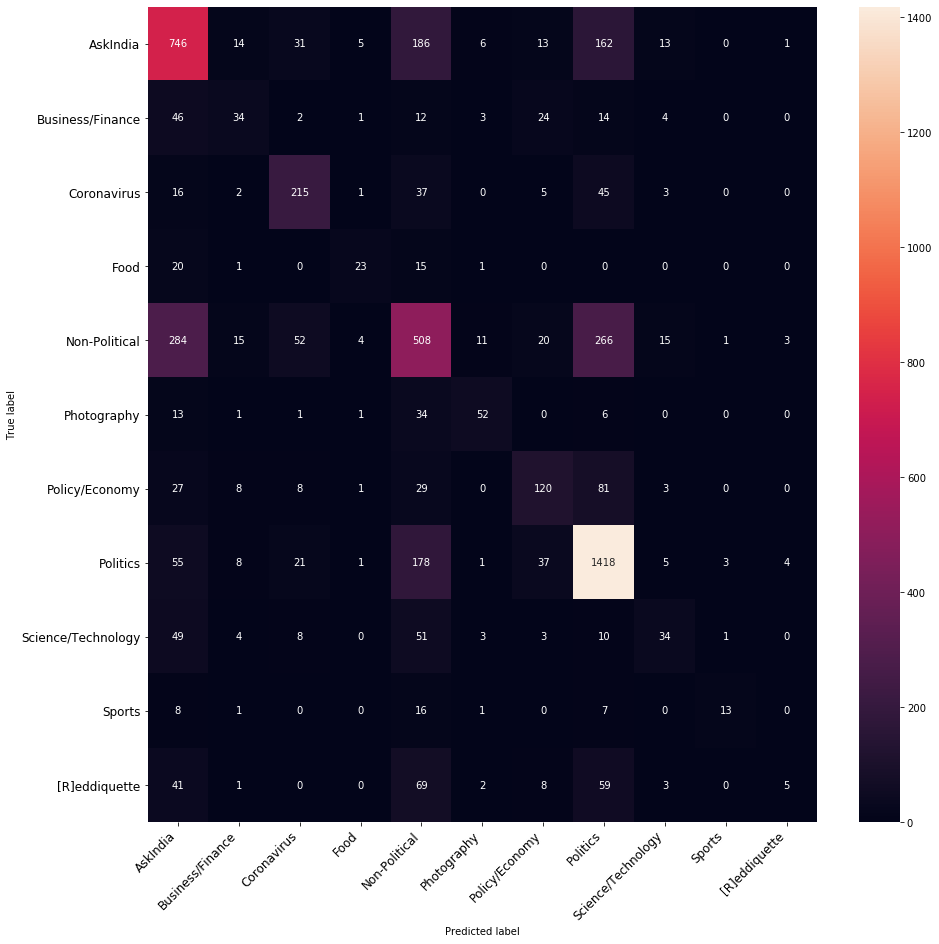

In [26]:
evaluate_model(mb, X_selected, y_train, X_test_selected, y_test, target_names=le.classes_)

### 2. ComplementNaiveBayes Model

In [31]:
y_resampled = y_train

Accuracy test: 0.56 (+/- 0.00)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.53      0.71      0.61      1177
  Business/Finance       0.33      0.14      0.20       140
       Coronavirus       0.59      0.70      0.64       324
              Food       0.58      0.43      0.50        60
     Non-Political       0.53      0.29      0.37      1179
       Photography       0.62      0.46      0.53       108
    Policy/Economy       0.48      0.35      0.40       277
          Politics       0.65      0.87      0.75      1731
Science/Technology       0.49      0.18      0.26       163
            Sports       0.51      0.48      0.49        46
     [R]eddiquette       0.50      0.01      0.02       188

          accuracy                           0.58      5393
         macro avg       0.53      0.42      0.43      5393
      weighted avg       0.56      0.58      0.55      5393

Test confusion matrix: 


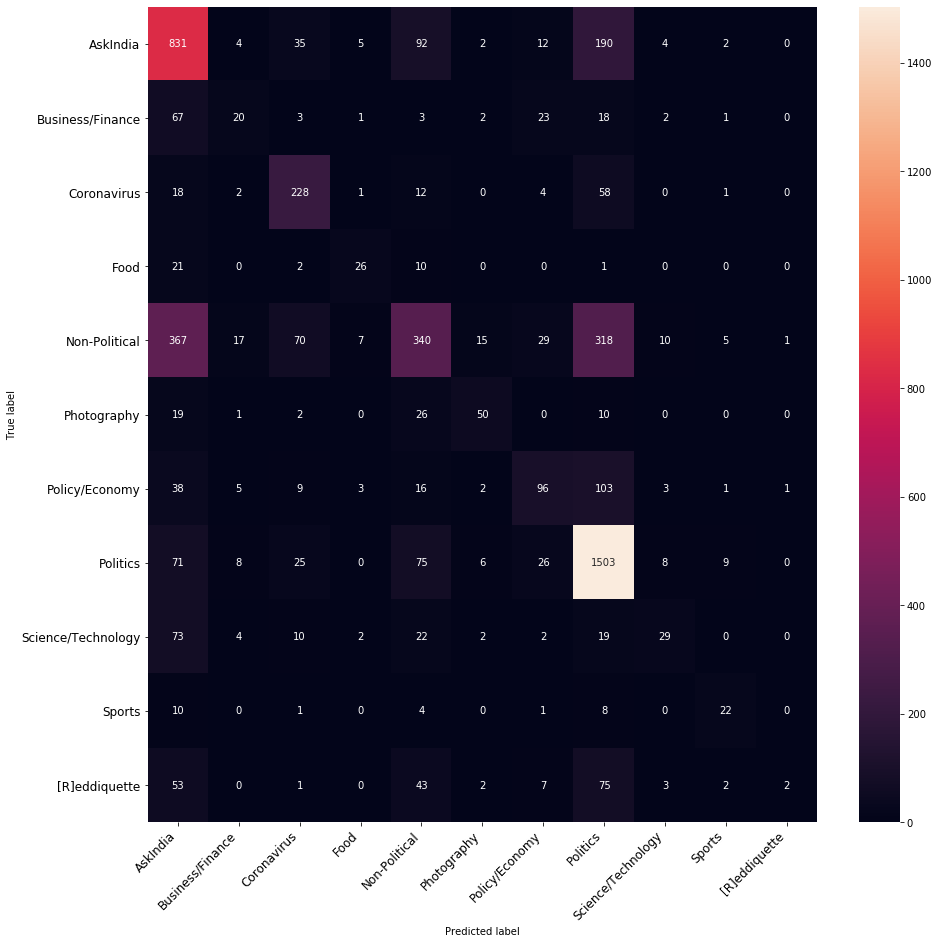

In [32]:
cb = ComplementNB()
cb.fit(X_selected, y_resampled)
evaluate_model(cb, X_selected, y_train, X_test_selected, y_test, target_names=le.classes_)

Accuracy: 0.58 (+/- 0.00)
Accuracy test: 0.57 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.50      0.69      0.58      1852
  Business/Finance       0.44      0.24      0.31       264
       Coronavirus       0.60      0.72      0.65       572
              Food       0.50      0.41      0.45       104
     Non-Political       0.55      0.32      0.40      2159
       Photography       0.63      0.50      0.56       204
    Policy/Economy       0.44      0.39      0.41       415
          Politics       0.68      0.86      0.76      3104
Science/Technology       0.49      0.21      0.29       324
            Sports       0.71      0.70      0.71       135
     [R]eddiquette       0.50      0.06      0.10       327

          accuracy                           0.59      9460
         macro avg       0.55      0.46      0.48      9460
      weighted avg       0.58      0.59      0.56      9460

Test confus

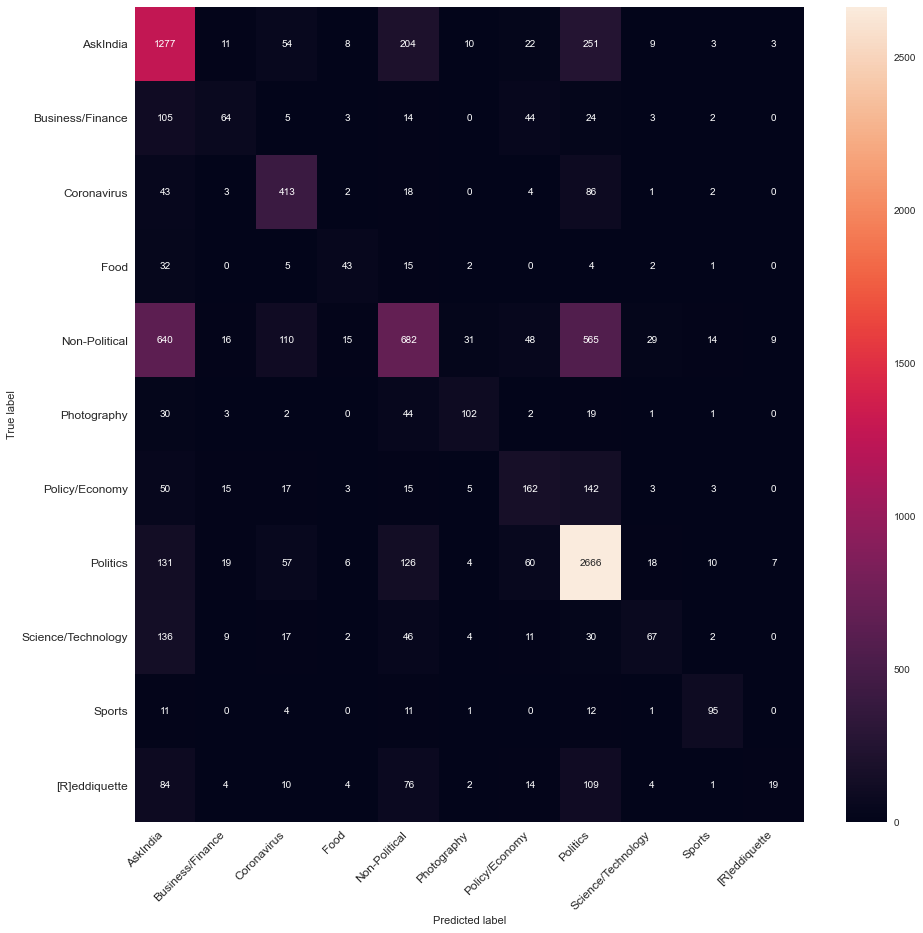

In [163]:
cb = ComplementNB()
cb.fit(X_selected, y_resampled)
evaluate_model(cb, X_selected, y_train, X_test_selected, y_test)

### 3. Support Vector Classification

In [33]:

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_selected, y_train)
evaluate_model(lsvc, X_selected, y_train, X_test_selected, y_test)


Accuracy test: 0.47 (+/- 0.01)
Test classification report: 


TypeError: object of type 'numpy.int32' has no len()

### 5. Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier

Accuracy test: 0.40 (+/- 0.00)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.66      0.36      0.47      1130
  Business/Finance       0.13      0.52      0.21       154
       Coronavirus       0.57      0.81      0.67       354
              Food       0.14      0.86      0.24        50
     Non-Political       0.47      0.11      0.18      1250
       Photography       0.21      0.77      0.33       100
    Policy/Economy       0.28      0.40      0.33       263
          Politics       0.78      0.51      0.61      1710
Science/Technology       0.15      0.40      0.22       160
            Sports       0.13      0.83      0.22        46
     [R]eddiquette       0.10      0.27      0.15       176

          accuracy                           0.40      5393
         macro avg       0.33      0.53      0.33      5393
      weighted avg       0.56      0.40      0.42      5393

Test confusion matrix: 


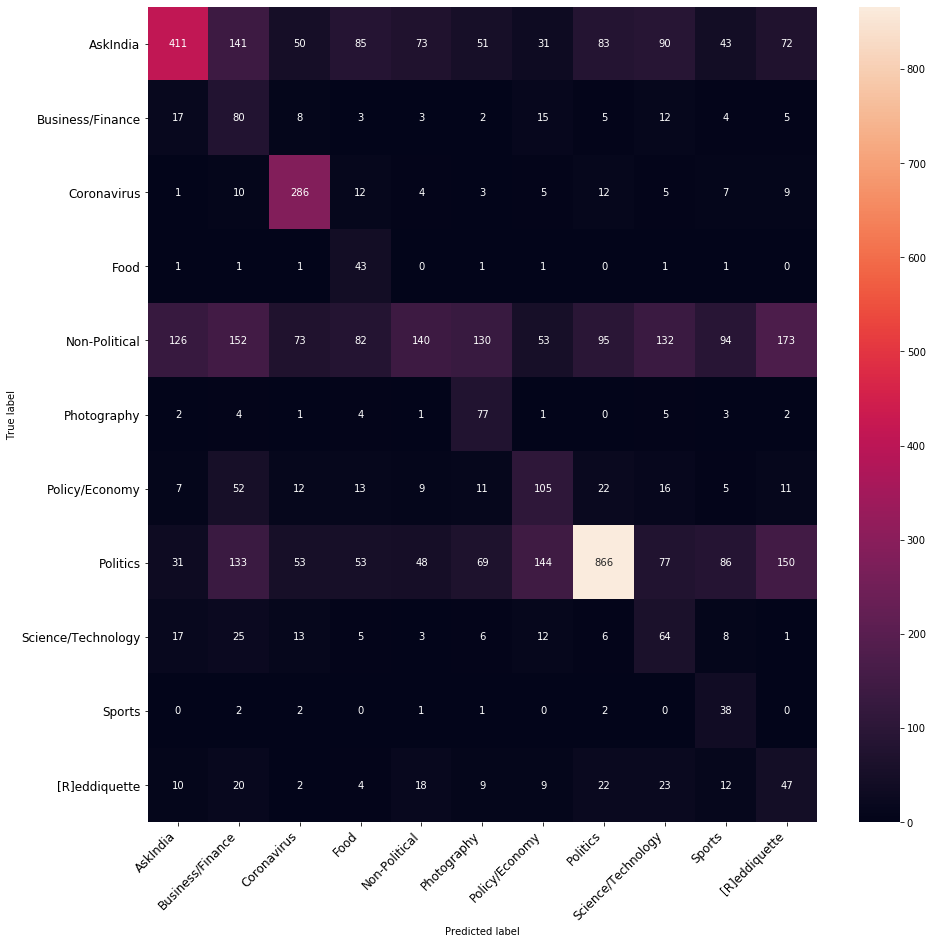

In [50]:
# default params
dt = RandomForestClassifier()
dt.fit(X_selected, y_resampled)
evaluate_model(dt, X_selected, y, X_test_selected, y_test, target_names=le.classes_)

### 6. Gradient Boost Classifier 

In [51]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [52]:
gbc = GradientBoostingClassifier()
gbc.fit(X_selected, y_resampled)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy test: 0.37 (+/- 0.00)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.66      0.28      0.40      1130
  Business/Finance       0.17      0.41      0.24       154
       Coronavirus       0.60      0.70      0.65       354
              Food       0.15      0.76      0.26        50
     Non-Political       0.41      0.21      0.28      1250
       Photography       0.33      0.73      0.45       100
    Policy/Economy       0.32      0.41      0.36       263
          Politics       0.84      0.41      0.55      1710
Science/Technology       0.16      0.44      0.23       160
            Sports       0.18      0.78      0.30        46
     [R]eddiquette       0.07      0.45      0.12       176

          accuracy                           0.37      5393
         macro avg       0.35      0.51      0.35      5393
      weighted avg       0.58      0.37      0.41      5393

Test confusion matrix: 


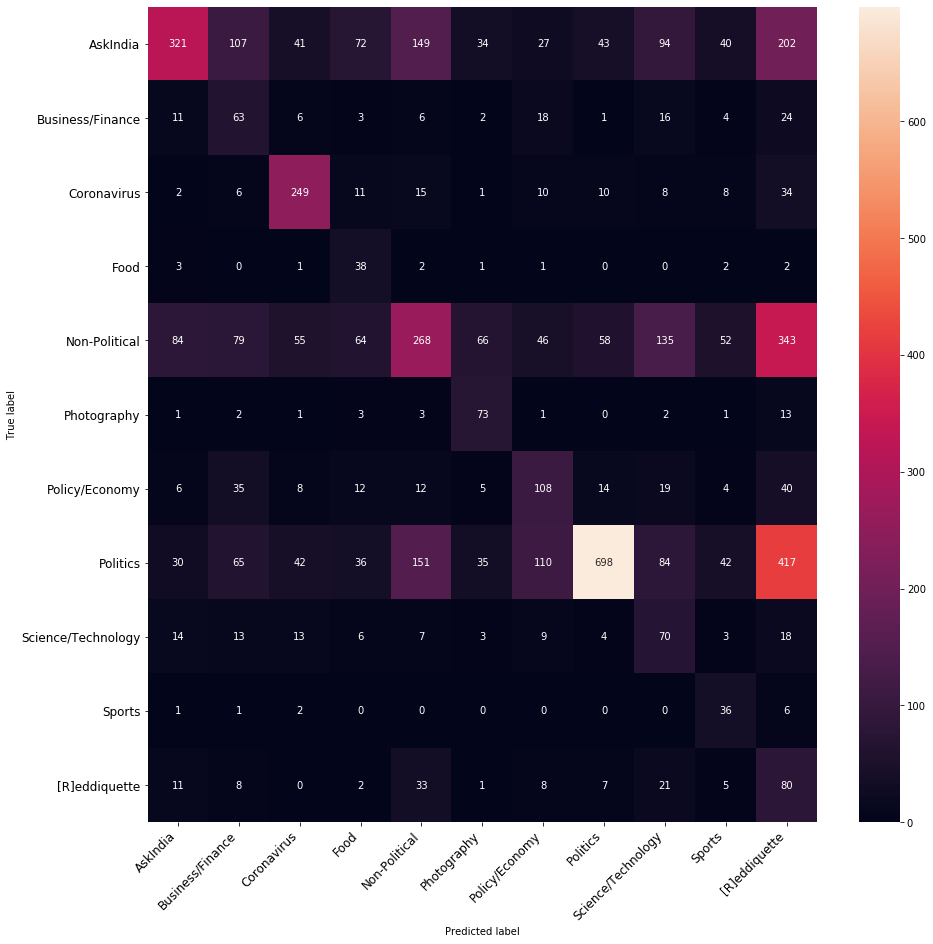

In [54]:
evaluate_model(gbc, X_selected, y, X_test_selected, y_test, target_names=le.classes_)

In [183]:
from rfd.b import evaluate_model

Accuracy test: 0.58 (+/- 0.00)
Test classification report: 
                    precision    recall  f1-score   support

          AskIndia       0.59      0.58      0.59      1852
  Business/Finance       0.53      0.19      0.28       264
       Coronavirus       0.62      0.67      0.65       572
              Food       0.52      0.28      0.36       104
     Non-Political       0.40      0.59      0.48      2159
       Photography       0.66      0.39      0.49       204
    Policy/Economy       0.61      0.30      0.40       415
          Politics       0.74      0.74      0.74      3104
Science/Technology       0.52      0.14      0.22       324
            Sports       0.70      0.47      0.56       135
     [R]eddiquette       0.35      0.09      0.14       327

          accuracy                           0.58      9460
         macro avg       0.57      0.40      0.45      9460
      weighted avg       0.59      0.58      0.56      9460

Test confusion matrix: 


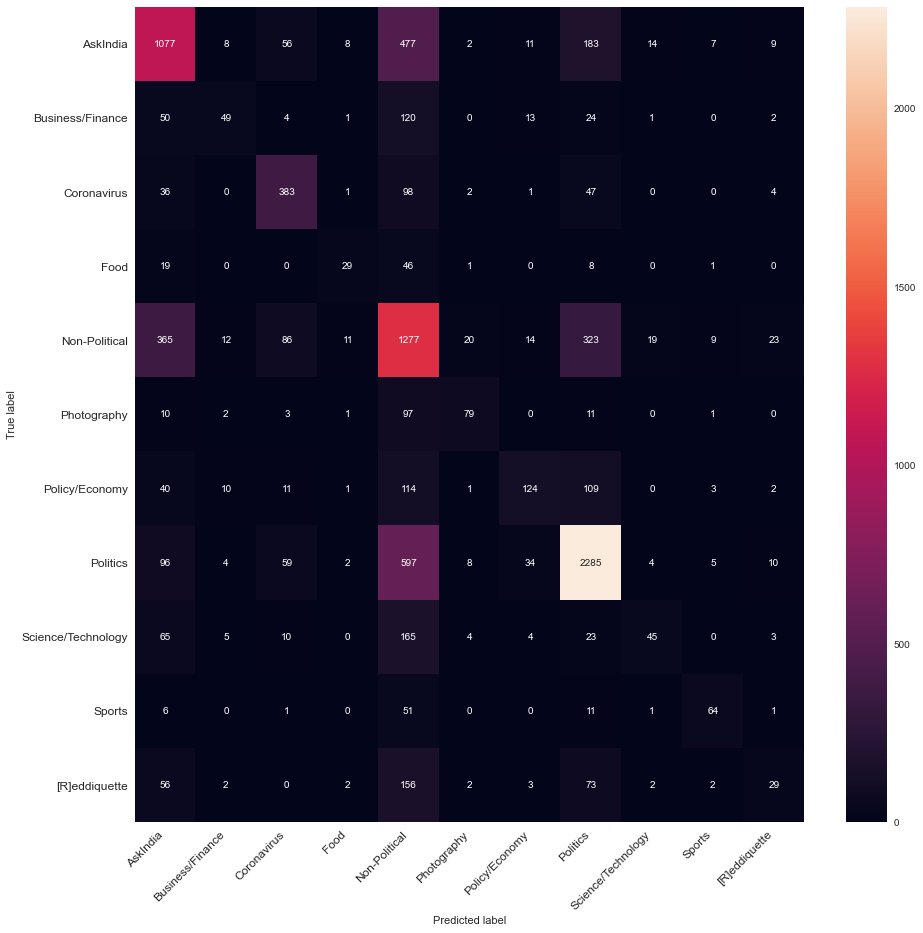

In [184]:
evaluate_model(gbc, X_selected, y, X_test_selected, y_test)

### 4. Text Classification using Flair 

- Classification using flair embeddings 

- Text was converted into fasttest format

- Due to computational resources it was trained on Google Colab colab.research.google.com

- A comprehensive Classification report is attached below

- Complete training logs including trained model can be obtained from here:

    - https://drive.google.com/file/d/1vc1f0em0pBZ4mFN7xYYOuuR5OHoi7Ioe/view?usp=sharing

## ![flair classification report](assets/flair-classification-report.jpg)

#### Click here to see the notebook: https://colab.research.google.com/drive/1fMgUPeOvAcUe9zJlZdTEJgqmf9xKBYCU

## Classification using customm DL models

In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt

# import our models from custom_models module visit the module in rfd subdir to see the architectures 
from rfd.custom_models import BiLSTM, CNN, BiLSTM_Attn
#embedding loader
from rfd.load_embedding import load_embedding


Using TensorFlow backend.


In [42]:
plt.style.use('seaborn')

In [3]:
df = pd.read_csv("df_processed.csv", usecols=['text', 'link_flair_text'])

In [4]:
le =  LabelEncoder().fit(df.link_flair_text)
df['label'] = le.transform(df.link_flair_text)

In [5]:
#  save the labelencoder object
with open("LabelEncoder.pkl", "wb") as fp:
    pickle.dump(le, fp)

#### Parameters

In [6]:
BATCH_SIZE=128
EPOCHS=20
max_len=500
vocabulary_size = 60000
es = EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=2) # ES will be somewhat same for all models

In [7]:
### Create sequence
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=max_len)

In [8]:
# with open("tokenizer.pkl", "wb") as fp:
#     pickle.dump(tokenizer, fp)

In [9]:
X_train, X_test, y_train, y_test  = train_test_split(
    data, 
    to_categorical(df['label'], num_classes=11),
    test_size=0.1
)

In [10]:
print(f'training data :{X_train.shape, y_train.shape}\ntesting data: {X_test.shape, y_test.shape}')

training data :((90181, 500), (90181, 11))
testing data: ((10021, 500), (10021, 11))


In [12]:
# embedding_matrix = load_embedding(
#     vocabulary_size=vocabulary_size,
#     tokenizer=tokenizer
# )

In [1]:
# embedding_matrix

### BiLSTM Model (with trainable embeddings)

In [51]:
## Checkpoints
lstm_mcp = ModelCheckpoint('trained_models/lstm.h5', monitor="val_accuracy", save_best_only=True)

In [52]:
bilstm = BiLSTM(
    vocabulary_size=vocabulary_size,
    max_len=max_len,
    n_classes=11
    )

In [53]:
bilstm.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    callbacks=[es, lstm_mcp],
    validation_data=(X_test, y_test)
)

Train on 90181 samples, validate on 10021 samples
Epoch 1/10
90181/90181 [==============================] - 631s 7ms/step - loss: 1.3292 - accuracy: 0.5572 - val_loss: 1.1246 - val_accuracy: 0.6220
Epoch 2/10
90181/90181 [==============================] - 611s 7ms/step - loss: 1.0081 - accuracy: 0.6613 - val_loss: 1.1039 - val_accuracy: 0.6318
Epoch 3/10
90181/90181 [==============================] - 619s 7ms/step - loss: 0.8283 - accuracy: 0.7231 - val_loss: 1.1522 - val_accuracy: 0.6171
Epoch 4/10
90181/90181 [==============================] - 633s 7ms/step - loss: 0.6651 - accuracy: 0.7799 - val_loss: 1.2722 - val_accuracy: 0.6060


In [13]:
model = load_model('trained_models/lstm.h5')

In [14]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_1/convolution}}]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_1/convolution}}]]
	 [[metrics/accuracy/Identity/_387]]
0 successful operations.
0 derived errors ignored.

In [1]:
le.classes_[np.argmax(model.predict(X_test))]

NameError: name 'le' is not defined

In [13]:
X_test[0].shape

(500,)

In [58]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

10021/10021 [==============================] - 3s 308us/step


[1.103851879741032, 0.6317732930183411]

### BiLSTM with pretrained embeddings (Glove Vector)

In [66]:
embeddings_index = dict()
f = open('./embeddings/glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [67]:
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [72]:
# If trainable(embedding layer) is false because we are using pretrained embedding
bilstm_glove =  BiLSTM(
    vocabulary_size=vocabulary_size,
    max_len=max_len,
    n_classes=11,
    trainable=False,
    embedding_matrix=embedding_matrix
)

In [74]:
# bilstm_glove.summary()

In [76]:
lstm_glove_mcp = ModelCheckpoint('trained_models/lstm-glove.h5', monitor="val_accuracy", save_best_only=True)

In [77]:
bilstm_glove.fit(
    x=X_train, 
    y=y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[lstm_glove_mcp, es], 
    validation_data=(X_test, y_test)
)

Train on 90181 samples, validate on 10021 samples
Epoch 1/10
90181/90181 [==============================] - 157s 2ms/step - loss: 1.4498 - accuracy: 0.5055 - val_loss: 1.2594 - val_accuracy: 0.5588
Epoch 2/10
90181/90181 [==============================] - 187s 2ms/step - loss: 1.2746 - accuracy: 0.5572 - val_loss: 1.2077 - val_accuracy: 0.5761
Epoch 3/10
90181/90181 [==============================] - 368s 4ms/step - loss: 1.2317 - accuracy: 0.5711 - val_loss: 1.1826 - val_accuracy: 0.5871
Epoch 4/10
90181/90181 [==============================] - 384s 4ms/step - loss: 1.2054 - accuracy: 0.5800 - val_loss: 1.1934 - val_accuracy: 0.5787
Epoch 5/10
 7552/90181 [=>............................] - ETA: 6:38 - loss: 1.1894 - accuracy: 0.5833

In [51]:
model = load_model('lstm-glove.pb')

In [52]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

5393/5393 [==============================] - 3s 517us/sample - loss: 1.1335 - acc: 0.6032


[1.1335249863815025, 0.60318935]

In [2]:
X_test[0]

NameError: name 'X_test' is not defined

### 8. Classification using Word Level CNN 

In [110]:
filter_sizes = [1,2,3,5]
num_filters = 42

def get_model():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(vocabulary_size, 100, weights=[embedding_matrix], trainable=False)(inp)
    #    x = SpatialDropout1D(0.4)(x)
    x = Reshape((maxlen, 100, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], 100),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], 100),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], 100), 
                                 kernel_initializer='he_normal', activation='tanh')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], 100),
                                 kernel_initializer='he_normal', activation='tanh')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    outp = Dense(11, activation="softmax")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = get_model()

In [111]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 500, 100)     6000000     input_16[0][0]                   
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 500, 100, 1)  0           embedding_18[0][0]               
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 500, 1, 42)   4242        reshape_5[0][0]                  
____________________________________________________________________________________________

In [112]:
mcp = ModelCheckpoint('cnn-glove.pb', monitor="val_accuracy", save_best_only=True)

In [73]:
hist = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[mcp, es], 
    validation_data=(X_test, y_test)
)

Train on 48535 samples, validate on 5393 samples
Epoch 1/10
48535/48535 [==============================] - 8s 165us/sample - loss: 1.0932 - acc: 0.6172 - val_loss: 1.2136 - val_acc: 0.5754
Epoch 2/10
48535/48535 [==============================] - 8s 162us/sample - loss: 1.0535 - acc: 0.6314 - val_loss: 1.2005 - val_acc: 0.5822
Epoch 3/10
48535/48535 [==============================] - 8s 164us/sample - loss: 1.0143 - acc: 0.6456 - val_loss: 1.2070 - val_acc: 0.5817
Epoch 4/10
48535/48535 [==============================] - 8s 170us/sample - loss: 0.9820 - acc: 0.6581 - val_loss: 1.2131 - val_acc: 0.5809


### 9. Classification using attention based LSTM

In [115]:
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers


from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf

In [121]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(vocabulary_size, 100, weights=[embedding_matrix], trainable=False)(inp)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 5, activation='relu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = AttentionWithContext()(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(11, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [123]:
model = model_lstm_atten(embedding_matrix=embedding_matrix)

In [125]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 500, 100)          6000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 496, 64)           32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 124, 256)          197632    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 124, 128)          1643

In [131]:
mcp = ModelCheckpoint('attention-lstm-glove.h5', monitor="val_accuracy", save_best_only=True,  save_weights_only=True)
es = EarlyStopping(monitor="val_accuracy", min_delta=0.005, patience=3)

In [132]:
hist = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=[mcp, es], 
    validation_data=(X_test, y_test)
)

Train on 48535 samples, validate on 5393 samples
Epoch 1/10
48535/48535 [==============================] - 350s 7ms/step - loss: 0.9235 - accuracy: 0.6675 - val_loss: 1.1695 - val_accuracy: 0.5995
Epoch 2/10
48535/48535 [==============================] - 299s 6ms/step - loss: 0.9010 - accuracy: 0.6749 - val_loss: 1.1753 - val_accuracy: 0.5898
Epoch 3/10
34048/48535 [====================>.........] - ETA: 1:13 - loss: 0.8824 - accuracy: 0.6822

KeyboardInterrupt: 

In [130]:
model = load_model("attention-lstm-glove.pb")

ValueError: Unknown layer: AttentionWithContext

## 9. Multimodal Architecture
- A reddit submisison has more than just text data (ie: num_comments, upvotes, downvotes etc) and in EDA plots suggest correlation between flair and these statistical features.
- Apart from the text we have some numerical and pos features of test data related to the submission.
- To process text and numerical features(listed above) we need an architecture which takes care of both numerical as well textual features of the submission.
- **LSTM for text data** and **DNN for numerical features**

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *

In [31]:
# read the data
df = pd.read_csv("df.csv")

In [20]:
if df.text.dtypes == "O":
    print(True)
else:
    print(False)

True


In [24]:
df.drop(['Unnamed'],  inplace=True)

KeyError: "['Unnamed'] not found in axis"

In [30]:
df.to_csv("df.csv", index=False)

In [36]:
df = df.reset_index(drop=True)

In [37]:
df.head()

,Unnamed: 0,author,can_mod_post,contest_mode,created_utc,full_link,id,is_crosspostable,is_meta,is_original_content,is_self,is_video,link_flair_text,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,score,selftext,send_replies,spoiler,stickied,title,url,comments,mean_comment_score,hour,day,title_selftext,text,word_count,char_count,word_density,char_count.1,num_words,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_stopwords,num_symbols,mean_word_len,num_unique_words,words_vs_unique,num_smilies,ant_slash_n,has_timestamp,has_http,nouns,adjectives,verbs,nouns_vs_length,adjectives_vs_length,verbs_vs_length,nouns_vs_words,adjectives_vs_words,verbs_vs_words,count_words_title,punct_percent,url_split
0,0,gurmanbh,False,False,1546303506,https://www.reddit.com/r/india/comments/abd9bt...,abd9bt,True,False,False,False,False,Non-Political,False,False,True,2,0,False,all_ads,/r/india/comments/abd9bt/palette_of_pollution/,False,1,NaN,True,False,False,Palette of Pollution,https://graphics.reuters.com/INDIA-POLLUTION/0...,These graphics are amazing. Thanks for sharing.,1.000000,6,1,Palette of Pollution,Palette of Pollution These graphics are amazi...,10,69,6.900000,69,10,4,0.057971,0,0,2,4,0,5.900000,10,1.000000,0,0,0,0,4,0,3,0.057971,0.000000,0.043478,0.400000,0.000000,0.300000,4,20.000000,graphics reuters india pollution vrbw index
1,1,askquestionsdude,False,False,1546303517,https://www.reddit.com/r/india/comments/abd9dz...,abd9dz,False,False,False,True,False,Business/Finance,False,False,True,0,0,False,all_ads,/r/india/comments/abd9dz/allow_banks_to_hold_p...,False,1,[removed],True,False,False,"Allow banks to hold passports of loan-takers, ...",https://www.reddit.com/r/india/comments/abd9dz...,NaN,0.000000,6,1,"Allow banks to hold passports of loan-takers, ...","Allow banks to hold passports of loan-takers, ...",11,75,6.818182,75,11,4,0.053333,0,0,4,2,0,5.818182,11,1.000000,0,0,0,0,5,1,3,0.066667,0.013333,0.040000,0.454545,0.090909,0.272727,2,36.363636,india comments abddz allow banks hold passport...
2,2,askquestionsdude,False,False,1546303587,https://www.reddit.com/r/india/comments/abd9r1...,abd9r1,True,False,False,False,False,Business/Finance,False,False,True,13,0,False,all_ads,/r/india/comments/abd9r1/allow_banks_to_hold_p...,False,1,NaN,True,False,False,"Allow banks to hold passports of loan-takers, ...",https://m.timesofindia.com/city/chennai/madras...,I'm expecting this suggestion to only be appli...,7.700000,6,1,"Allow banks to hold passports of loan-takers, ...","Allow banks to hold passports of loan-takers, ...",203,1243,6.123153,1243,203,41,0.032985,1,5,62,86,3,5.088670,152,0.748768,0,8,2,1,72,14,41,0.057924,0.011263,0.032985,0.354680,0.068966,0.201970,24,30.541872,timesofindia city chennai madras high court su...
3,3,askquestionsdude,False,False,1546304415,https://www.reddit.com/r/india/comments/abde0g...,abde0g,True,False,False,False,False,Policy/Economy,False,False,True,3,0,False,all_ads,/r/india/comments/abde0g/tamil_nadu_to_usher_i...,False,1,NaN,True,False,False,Tamil Nadu to usher in New Year on green note ...,https://www.livemint.com/Politics/95rPBVTWmQqM...,Cautiously Optimistic. Enforcement is going to...,9.666667,6,1,Tamil Nadu to usher in New Year on green note ...,Tamil Nadu to usher in New Year on green note ...,47,267,5.680851,267,47,12,0.044944,0,0,5,19,0,4.680851,42,0.893617,0,0,0,0,22,1,7,0.082397,0.003745,0.026217,0.468085,0.021277,0.148936,8,10.638298,livemint politics rpbvtwmqqmryeqatwjm tamil na...
4,4,YSayed,False,False,1546305048,https://www.reddit.com/r/india/comments/abdhdg...,abdhdg,True,False,False,True,False,Business/Finance,False,False,True,0,0,False,all_ads,/r/india/comments/abdhdg/heera_gold_timeline_1...,False,1,"Background – Pre 2007\n\nBefore anything, Nowh...",True,False,False,Heera Gold Timeline #1 - Background - Pre 2007,https://www.reddit.com/r/india/comments/abdhdg...,NaN,0.000000,6,1,Heera Gold Timeline

## Pre-trained Models

### Ref: https://github.com/ThilinaRajapakse/simpletransformers

### 10. Classification uisng DistilBERT

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
tqdm.pandas()

In [2]:
# read the csv file
df = pd.read_csv("df.csv", usecols=['text', 'link_flair_text'])

In [3]:
# encode the categorical flair into numerical labels
le = LabelEncoder().fit(df.link_flair_text)
df['label'] = le.transform(df.link_flair_text)

In [4]:
# split the dataset into train/test set
train, test = train_test_split(df[['text', 'label']], test_size=0.1) 

In [5]:
print(train.shape, test.shape)

(90334, 2) (10038, 2)


In [6]:
train.head()

,text,label
92222,No economic task force for COVID-19 yet Modi'...,2
13012,"Jumla cycle. In the last one month alone, Modi...",7
47921,Remembering Bharatendu Harishchandra on Hindi ...,4
28102,This was on my Uber cab's rear view mirror. It...,4
86082,The hearts of Muslims all over the world are g...,7


In [19]:
from simpletransformers.classification import ClassificationModel
from args import args

#### Fine-tuning the DistillBERT

In [22]:
from multiprocessing import cpu_count

In [23]:
args = {
    "output_dir": "outputs/",
    "cache_dir": "cache/",
    "best_model_dir": "outputs/best_model/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 128,
    "train_batch_size": 128,
    "eval_batch_size": 128,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 1,
    "weight_decay": 0,
    "learning_rate": 1e-4,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": False,

    "logging_steps": 50,
    "evaluate_during_training": False,
    "evaluate_during_training_steps": 2000,
    "evaluate_during_training_verbose": False,
    "use_cached_eval_features": False,
    "save_eval_checkpoints": True,
    "no_cache": False,
    "save_model_every_epoch": True,
    "tensorboard_dir": None,

    "overwrite_output_dir": True,
    "reprocess_input_data": True,

    "process_count": cpu_count() ,
    "n_gpu": 1,
    "silent": False,
    "use_multiprocessing": True,

    "wandb_project": None,
    "wandb_kwargs": {},

    "use_early_stopping": True,
    "early_stopping_patience": 2,
    "early_stopping_delta": 0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize": True,

    "manual_seed": 0,
    "encoding": None,
    "config": {},
}

In [24]:
# default args
model = ClassificationModel('distilbert', 'distilbert-base-cased', num_labels=11,  args=args)

In [25]:
model.train_model(train_df=train)

Current iteration:   0%|          | 0/706 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 6.00 GiB total capacity; 4.51 GiB already allocated; 42.13 MiB free; 4.54 GiB reserved in total by PyTorch)

### 11. XLNet 

### 12. Multimodal Architecture for Text Classification (DNN+LSTM)

### Summary 